In [2]:
import numpy as np
import cv2
import matplotlib as plt

In [58]:
def mean_saliency(image):
    h, w, n_chan = image.shape
    w2 = min(h,w)
    scales = [w2/2, w2/4, w2/8]
    c_mat = np.zeros((h,w))
    for s in range(3):
        saliency = extract_saliency(image, scales[s])
        c_mat += saliency
    return c_mat

def get_limits(i, j, n_H, n_W, W_R):
    maxi_x = min(n_H, i + 1 + W_R//2)
    maxi_y = min(n_W, j + 1 + W_R//2)
    mini_x = max(0, i - W_R//2)
    mini_y = max(0, j - W_R//2)
    N = (maxi_x - mini_x)*(maxi_y - mini_y)
    return mini_x, mini_y, maxi_x, maxi_y, N
    
def extract_saliency(img):
    n_H, n_W, n_channel = img.shape
    W_R2 = min(n_H,n_W)/16
    N2 = W_R2**2
    print(W_R2)
    integral_img = cv2.integral(im)
    saliency_map = np.zeros((n_H,n_W))
    for i in range(n_H):
        for j in range(n_W):
            mini_x, mini_y, maxi_x, maxi_y, N = get_limits(i, j, n_H, n_W, W_R2)
            tmp = 1.0*(integral_img[mini_x,mini_y,:] + integral_img[maxi_x,maxi_y,:]\
                       - (integral_img[mini_x,maxi_y,:] \
                          + integral_img[maxi_x,mini_y,:]))/N
            saliency_map[i,j] = np.linalg.norm(img[i,j,:]-np.array(tmp))
    return saliency_map

    
def find_neighbors(pos,hist):
    x,y,z = pos
    n_bins = hist.shape[0]
    min_x, max_x = cyclic_coord(x, n_bins)
    min_y, max_y = cyclic_coord(y, n_bins)
    min_z, max_z = cyclic_coord(y, n_bins)
    neighbors_coord = np.array([[min_x, x, max_x], [min_y, y, max_y], [min_z, z, max_z]])
    neighbors = hist[min_x:max_x+1, min_y:max_y+1, min_z:max_z+1]
    print(neighbors)
    print(neighbors_coord)
    return neighbors_coord, neighbors
    
def cyclic_coord(x, n_bins):
    if x == 0:
        min_x = n_bins
        max_x = 1
    elif x == n_bins:
        min_x = n_bins - 1
        max_x = 0
    else:
        min_x = x - 1
        max_x = x + 1
    return min_x, max_x

def uphill_move(peak, hist):
    x, y, z = peak.pos
    neigh_coord, neighbors = find_neighbors(peak.pos, hist)
    true_neigh = np.delete(neighbors,13)
    if hist[x,y,z] >= true_neigh.all() and hist[x,y,z] > true_neigh.any():
        peak.is_peak = True
    elif hist[x,y,z] == neighbors.all():
        peak.pos = neigh_coord[0,1], neigh_coord[1,1], neigh_coord[2,2]  
    else:
        loc_x, loc_y, loc_z = np.unravel_index(np.argmax(neighbors, axis=None), neighbors.shape)
        peak.pos = neigh_coord[0,loc_x], neigh_coord[1,loc_x], neigh_coord[2,loc_x]
    return peak
    
def find_peaks(hist, n_bins):
    not_visited = []
    peaks = []
    for i in range(n_bins):
        for j in range(n_bins):
            for k in range(n_bins):
                not_visited.append((i,j,k))
    peak = Peak((0,0,0), hist[0,0,0])
    not_visited.remove((0,0,0))
    
    while peak.hist_val == 0:
        new_ind = np.random.randint(0,len(not_visited),1)[0]
        hist_ind = not_visited[new_ind]
        not_visited.remove(hist_ind)
        peak.pos = hist_ind
        peak.hist_val = hist[hist_ind]
        
    while len(not_visited) != 0:
        print(len(not_visited))
        while peak.is_peak == False:
            peak = uphill_move(peak, hist)
            if peak.pos in not_visited:
                not_visited.remove[peak.pos]
        peaks.append(peak)
        
        while peak.hist_val == 0:
            new_ind = np.random.randint(0,len(not_visited),1)
            hist_ind = not_visited[new_ind]
            not_visited.remove(hist_ind)
            peak.pos = hist_ind
            peak.hist_val = hist[hist_ind]
            
    return len(peaks)
    
class Peak:
    def __init__(self, pos, hist_val):
        self.pos = pos
        self.hist_val = hist_val
        self.is_peak = False
        
        

(501, 420, 3)


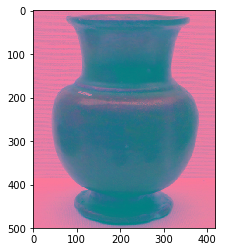

In [28]:
image = cv2.imread("MSO/img/COCO_COCO_train2014_000000026171.jpg")
im = cv2.cvtColor(image,cv2.COLOR_BGR2LAB)
%matplotlib inline
plt.pyplot.imshow(im)
i_im = cv2.integral(im)
print(i_im.shape)

26
(500, 419)


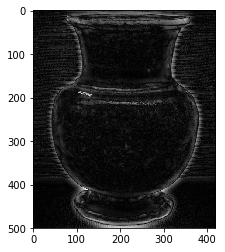

In [31]:
s = extract_saliency(im)
print(s.shape)
plt.pyplot.imshow(s,cmap='gray')

In [59]:
hist = cv2.calcHist([im],[0,1,2],None,[16,16,16],[0,100,-128,127,-128,127])
k = find_peaks(hist,16)

3691
[[[ 0.  0.]
  [ 0. 21.]]

 [[ 0.  1.]
  [ 0.  3.]]

 [[ 0.  1.]
  [ 0.  0.]]]
[[ 9 10 11]
 [14 15 16]
 [14 15 16]]


IndexError: index 13 is out of bounds for axis 0 with size 12

In [19]:
x= 4,5,6
y = x,7
print(y)

((4, 5, 6), 7)


In [20]:
x = range(3)
y = range(3)
z = range(3)
X,Y,Z = np.meshgrid(x,y,z)
print(X)
print(Y)
print(Z)


[[[0 0 0]
  [1 1 1]
  [2 2 2]]

 [[0 0 0]
  [1 1 1]
  [2 2 2]]

 [[0 0 0]
  [1 1 1]
  [2 2 2]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]]

 [[2 2 2]
  [2 2 2]
  [2 2 2]]]
[[[0 1 2]
  [0 1 2]
  [0 1 2]]

 [[0 1 2]
  [0 1 2]
  [0 1 2]]

 [[0 1 2]
  [0 1 2]
  [0 1 2]]]


In [24]:
x = np.arange(9).reshape((3,3))
print(x)
ind = [1,1]
print(x[ind])

[[0 1 2]
 [3 4 5]
 [6 7 8]]
[[3 4 5]
 [3 4 5]]


In [25]:
x = [(1,2), (3,4)]
s = np.random.choice(x)

ValueError: a must be 1-dimensional